# Backtest a  Strategy

In [1]:
%matplotlib inline
import quantstats as qs
# extend pandas functionality with metrics, etc.
qs.extend_pandas()
from bots.financial_trading.get_historical_data_financial import save_historical, _get_historical_data
import datetime as dt
import pandas as pd
from smartbots.engine.data_reader import read_data_to_dataframe
from smartbots.engine.portfolio_constructor import Portfolio_Constructor

/usr/local/lib/python3.8/site-packages/arctic/store/_pandas_ndarray_store.py:8: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## 1) Download Historical Data from Data Provider and save into the database.
If you already have the data in a database, you can skip this step and go to the next.

Read the csv file is in the data folder

If there are already some data in the database, it will update only the new data.


In [3]:
# Parameters
provider = 'darwinex'
name_library = f'{provider}_historical_1min'
_get_historical_data(name_library)
print(f'* Historical data for {provider} saved')

Library created, but couldn't enable sharding: no such command: 'enablesharding', full error: {'ok': 0.0, 'errmsg': "no such command: 'enablesharding'", 'code': 59, 'codeName': 'CommandNotFound'}. This is OK if you're not 'admin'


Symbol EURJPY saved.
Symbol AUDNZD saved.
* Historical data for darwinex saved


## 2) Read Historical Data from Database and Visualize it.


In [13]:
provider = 'darwinex'
interval = '1min'
symbols = ["AUDNZD","EURJPY"] # List of symbols to download from provider
start_date = dt.datetime(2022,1,1) # Start date of data to download
end_date = dt.datetime.utcnow() # End date of data to download
df1 = read_data_to_dataframe(symbols[0], provider,start_date=start_date,end_date=end_date, interval=interval)
df2 = read_data_to_dataframe(symbols[-1], provider,start_date=start_date,end_date=end_date,interval=interval)
df = pd.concat([df1,df2],axis=0)


<AxesSubplot:xlabel='date'>

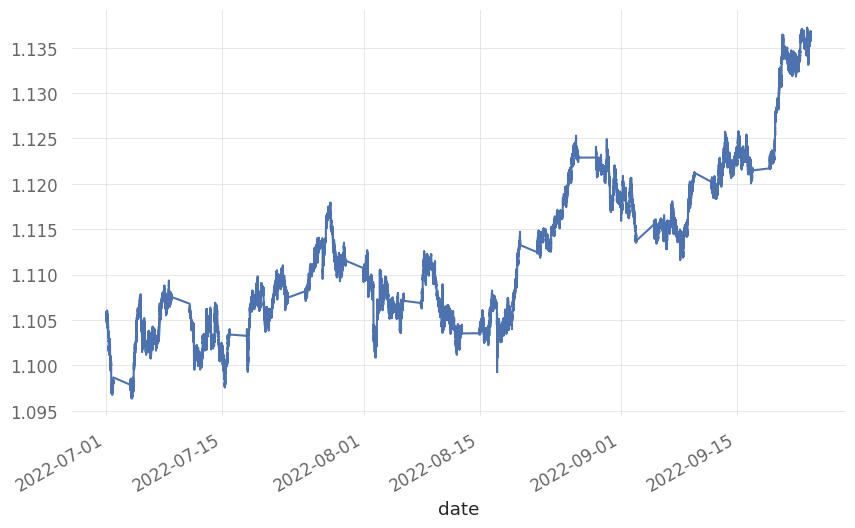

In [14]:
df1.close.plot()

## 3) BackTesting

### Settings

In [15]:
provider = 'darwinex'
inicial_cash = 50000 # initial capital for the portfolio
start_date = dt.datetime(2022,8,1) # Start date for backtesting


strategy1 = {'id': 1, # unique id for strategy to run
             'strategy': 'Simple_Avg_Cross', # strategy name, create in smartbots/crypto/strategies
             'params': {'ticker': 'AUDNZD',
             'short_period': 10,
             'long_period': 500,
             'quantity': 500,
             'limit_save_values':1000,'point_value':1,'slippage':0}}

strategy2 = {'id': 2, # unique id for strategy to run
             'strategy': 'Simple_Avg_Cross', # strategy name, create in smartbots/crypto/strategies
             'params': {'ticker': 'EURJPY',
             'short_period': 10,
             'long_period': 500,
             'quantity': 500,
             'limit_save_values':1000,'point_value':1,'slippage':0}}



conf_portfolio = {'Name': 'PortfolioForex1',
                  'Data_Sources': 
                  [{'tickers': ['AUDNZD','EURJPY'],
                   'event_type': 'bar',
                   'historical_source': 'mongoDB',
                   'historical_library': f'{provider}_historical_1min'}],
                   'Strategies': 
                    [strategy1, strategy2]}

In [20]:
portfolio = Portfolio_Constructor(conf_portfolio, run_real=False, asset_type='financial',
                                  send_orders_to_broker=False, start_date=start_date,
                                  inicial_cash=inicial_cash)
portfolio.run_simulation() # backtest 

info_port = portfolio.get_saved_values_strategy() # read change of positions

Loading AUDNZD from 2022-08-01 00:00:00
Loading EURJPY from 2022-08-01 00:00:00
Loading AUDNZD from 2022-09-01 00:00:00
Loading EURJPY from 2022-09-01 00:00:00


## Statistics

Plots and statistics of the Strategies and the Portfolio.

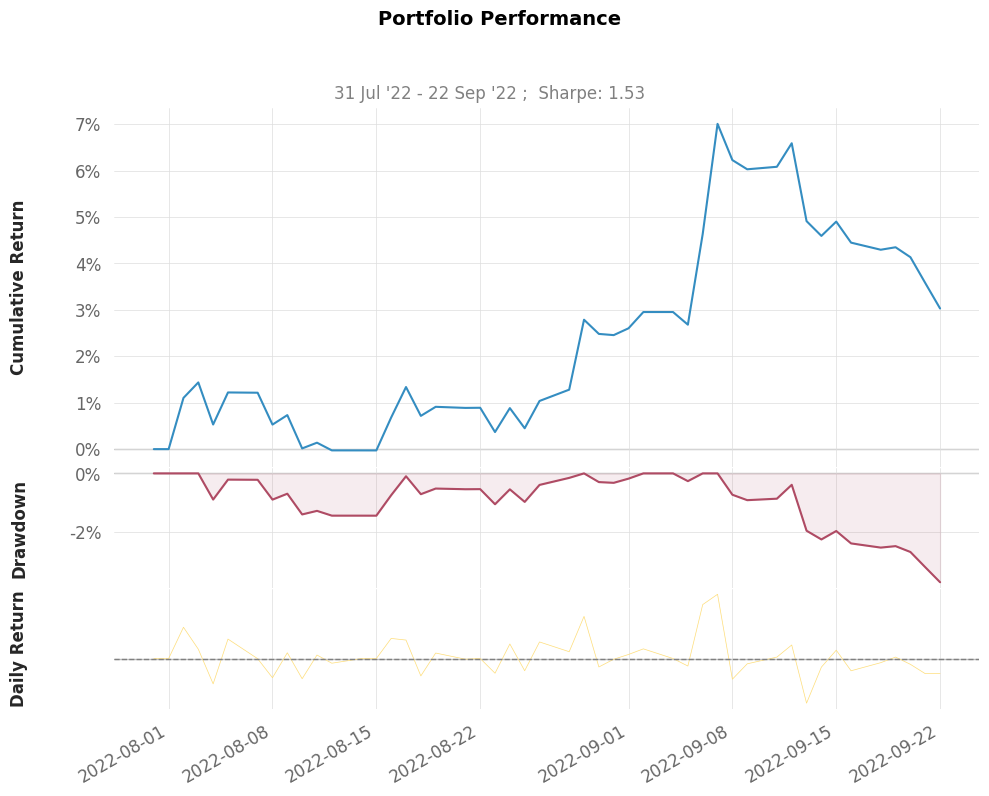

In [21]:
equities =portfolio.equity_handler.get_equities()
portfolio = equities['equity_portfolio']['equity']
port_return = portfolio.pct_change()
qs.plots.snapshot(portfolio, title='Portfolio Performance')

In [22]:
qs.reports.metrics(port_return,mode= 'basic')

                    Strategy
------------------  ----------
Start Period        2022-08-01
End Period          2022-09-22
Risk-Free Rate      0.0%
Time in Market      96.0%

Cumulative Return   3.03%
CAGR﹪              23.3%

Sharpe              1.55
Prob. Sharpe Ratio  75.34%
Sortino             2.79
Sortino/√2          1.97
Omega               1.33

Max Drawdown        -3.72%
Longest DD Days     25

Gain/Pain Ratio     0.33
Gain/Pain (1M)      -

Payoff Ratio        1.46
Profit Factor       1.33
Common Sense Ratio  2.56
CPC Index           0.93
Tail Ratio          1.92
Outlier Win Ratio   3.91
Outlier Loss Ratio  3.15

MTD                 0.56%
3M                  3.03%
6M                  3.03%
YTD                 3.03%
1Y                  3.03%
3Y (ann.)           23.3%
5Y (ann.)           23.3%
10Y (ann.)          23.3%
All-time (ann.)     23.3%

Avg. Drawdown       -1.44%
Avg. Drawdown Days  11
Recovery Factor     0.82
Ulcer Index         0.01
Serenity Index      0.62
